# Image Generation - Surprise Storm
This notebook will show the minimal workflow necessary to predict the next 3 images of the surprise storm. The model used is a ConvLSTM trained on 2 datasets similar to `tst` in terms of images and `tst` itself.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torch.optim import Adam
from IPython.display import clear_output

The import below was made within Google Colab, so if you're running the model in your local environment, replace the code below with

```python
from prediction import HurricaneDatasetImage, Seq2SeqImage
```

In [2]:
# from dataloaderimage import HurricaneDatasetImage
# from seq2seqimage import Seq2SeqImage
from prediction import HurricaneDatasetImage, Seq2SeqImage, get_last_images, load_and_preprocess_image, save_image


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Initialising the dataset

Concatenating dataset, training and testing the model, loading into dataloader with batch size of 8 and the dataloader shuffles the sequences between the storms to ensure that our model is able to generalise well on the specific kinds of storms we are training on. We used 128x128 images to train our model since they are smaller and easier to process, and they showcase nearly the same amount of detail as the original 366x366 images.

In [ ]:
storms = ['pjj', 'sxb', 'tst']
hurricane_dataset = ConcatDataset([HurricaneDatasetImage(image_folder=f'gdrive/MyDrive/images_and_data/{storm}', image_size=(128, 128), channels=1) for storm in storms])


train_size = int(0.8 * len(hurricane_dataset))
val_size = len(hurricane_dataset) - train_size

train_dataset = Subset(hurricane_dataset, range(train_size))
val_dataset = Subset(hurricane_dataset, range(train_size, len(hurricane_dataset)))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

## Initialising and Training Model
We initialise our Seq2SeqImage model for the set image size and use the Adam optimiser with a learning rate of 2e-4, which was found to be yield more precise images more quickly. We also use the BCELoss function to calculate the loss between the predicted and actual images. We train the model for 50 epochs, to ensure that our images are as accurate as possible.

In [ ]:
model = Seq2SeqImage(num_channels=1, num_kernels=64,
kernel_size=(3, 3), padding=(1, 1), activation="relu",
frame_size=(128, 128), num_layers=6).to(device)

optim = Adam(model.parameters(), lr=2e-4)

criterion = nn.BCELoss(reduction='sum')

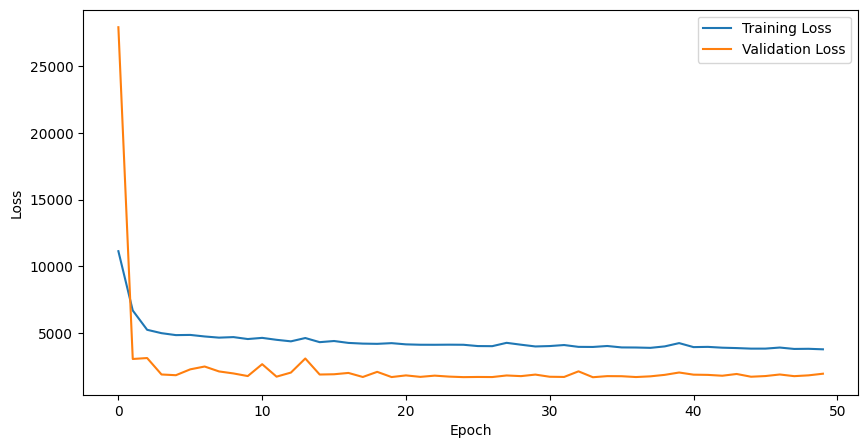

Epoch 50/50, Train Loss: 3798.2929, Validation Loss: 1972.8897


In [7]:
def train_model_with_plot(model, train_loader, val_loader, criterion, optim, num_epochs=25, device=device):
    """Train the model and plot the liveloss.
    
    Parameters
    ----------
    model : torch.nn.Module
        The neural network model to be trained.
    
    train_loader : torch.utils.data.DataLoader
        DataLoader for the training dataset.
    
    val_loader : torch.utils.data.DataLoader
        DataLoader for the validation dataset.
    
    criterion : torch.nn.modules.loss
        Loss function used to calculate the training and validation losses.
    
    optim : torch.optim.Optimizer
        Optimization algorithm used to update the model's weights.
    
    num_epochs : int, optional
        Number of epochs to train the model. Defaults to 25.
    
    device : str, optional
        Device to train the model on ('cuda' or 'cpu'). Defaults to 'cuda'.

    """
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0
        model.train()
        for input, target in train_loader:
            input, target = input.to(device), target.to(device)
            optim.zero_grad()
            output = model(input)
            loss = criterion(output.flatten(), target.flatten())
            loss.backward()
            optim.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for input, target in val_loader:
                input, target = input.to(device), target.to(device)

                output = model(input)
                loss = criterion(output.flatten(), target.flatten())
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

train_model_with_plot(model, train_loader, val_loader, criterion, optim, num_epochs=50)

As we can see above, after epochs our loss has significantly decreased over time. Since we are training on 3 datasets and roughly 900 images, the loss is expected to be high generally speaking.

## Saving and Loading the Model
For the sake of sustainability and reusability of the code, we save the model and load it back in to ensure that the model is working as expected.

In [ ]:
model_save_path = 'final_04_128_2.pth'
torch.save(model.state_dict(), model_save_path)

In [ ]:
model = Seq2SeqImage(num_channels=1, num_kernels=64, kernel_size=(3, 3), padding=(1, 1), activation="relu", frame_size=(128, 128), num_layers=3).to(device)
model.load_state_dict(torch.load('../models/128_image_model.pth'))
model = model.to(device)

## Generating Surprise Storm Images
In order to predict the 3 future images, we load 15 images from a dataset, and predict the next 3 images recursively. This means that, the 2nd generated image uses the 1st generated image as input, and the 3rd generated image uses the 2nd generated image as input. Alternatively, we had a model that predicted all 3 images at once, but the results were not as accurate as we would have liked and the images were quite blurry.

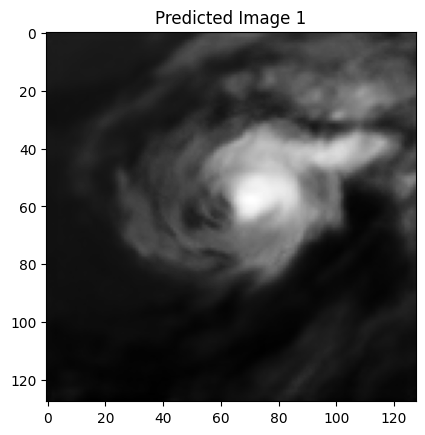

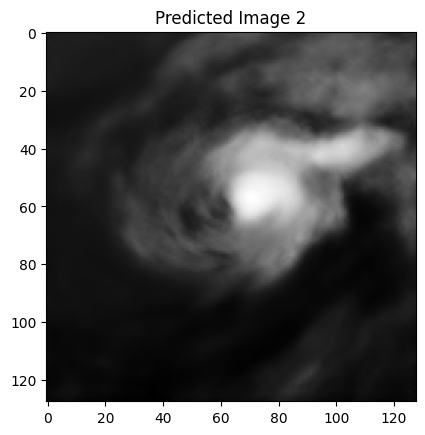

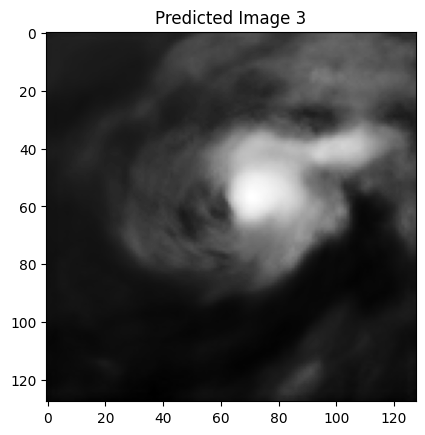

In [ ]:
def predict_next_images(model, initial_images, num_predictions=3):
    """
    Use model to predict image(s).

    Parameters
    ----------
    model: torch.nn.Module
        The neural network model to be evaluated.
    
    initial_images: torch.tensor
        A sequence of images.
    
    num_predictions: int
        The number of images needed to be predicted. Default to 3.

    Return
    ------
    torch.tensor
        A sequence of predicted images.
    """
    current_sequence = torch.stack(initial_images, dim=1).to(device)
    predicted_images = []

    for _ in range(num_predictions):
        with torch.no_grad():
            predicted_image = model(current_sequence.unsqueeze(0)).squeeze(0)
            new_image = predicted_image[-1, :, :].unsqueeze(0).unsqueeze(0)
            current_sequence = torch.cat((current_sequence[:, 1:, :, :], new_image), dim=1)
            predicted_images.append(new_image.squeeze(0).cpu())
    return predicted_images

image_directory = 'gdrive/MyDrive/tst'
image_paths = [os.path.join(image_directory, f) for f in get_last_images(image_directory)]
initial_images = [load_and_preprocess_image(path) for path in image_paths]

predicted_images = predict_next_images(model, initial_images)

for i, img in enumerate(predicted_images):
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Predicted Image {i+1}")
    plt.show()

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    image_name = f"predicted_image_128_{i+1}_{timestamp}.jpg"
    save_image(img, os.path.join('outputs/', image_name))


We can see above that the model has generated 3 images, you can notice a slight change in the storm's shape and size, which is expected since the model is predicting the future images based on the previous ones.